<a href="https://colab.research.google.com/github/mcagriaksoy/TreeSegmentation/blob/main/SAM_TreeSegmentationDatasetCreator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
#####################################################
# Hello! Welcome to my playground! It is Mehmet Cagri Aksoy - 2023
# more information about me: https://github.com/mcagriaksoy
# This notebook is created for educational and academic purposes.
# References:
# https://towardsdatascience.com/meta-ai-introduces-revolutionary-image-segmentation-model-trained-on-1-billion-masks-8f13c86a13a2
#####################################################

from IPython.display import display, HTML
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
import torch
import torchvision


print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA is available:", torch.cuda.is_available())


PyTorch version: 2.0.0+cu118
Torchvision version: 0.15.1+cu118
CUDA is available: True


In [6]:

import sys
!{sys.executable} -m pip install opencv-python matplotlib
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'  
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-fajnvzha
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-fajnvzha
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
--2023-05-15 18:18:11--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 99.86.4.77, 99.86.4.48, 99.86.4.124, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|99.86.4.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2564550879 (2.4G) [binary/octet-stream]
Saving to: ‘sam_vit_h

In [7]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   

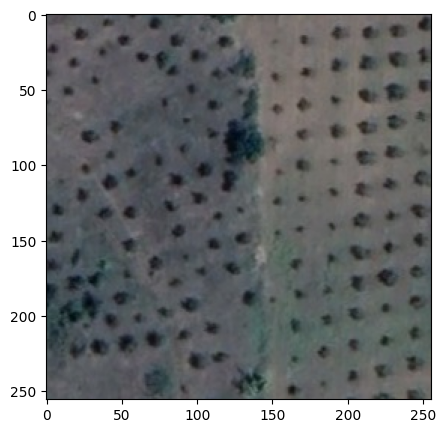

In [18]:
image = cv2.imread('/content/256X256.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
plt.figure(figsize=(5,5))
plt.imshow(image)
plt.axis('on')
plt.show()

In [19]:
sam_checkpoint = "/content/sam_vit_h_4b8939.pth"
device = "cuda"
model_type = "default"

import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

predictor.set_image(image)

In [ ]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)
    polygons = []
    color = []
    for ann in sorted_anns:
        m = ann['segmentation']
        img = np.ones((m.shape[0], m.shape[1], 3))
        color_mask = np.random.random((1, 3)).tolist()[0]
        for i in range(3):
            img[:,:,i] = color_mask[i]
        ax.imshow(np.dstack((img, m*0.35)))

from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

#######################
#More info about the fine tuning: https://replicate.com/pablodawson/segment-anything-automatic
#mcagriaksoy
#######################

mask_generator = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=8,
    pred_iou_thresh=0.94,
    stability_score_thresh=0.96,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=800
)

masks = mask_generator.generate(image)
print(len(masks))

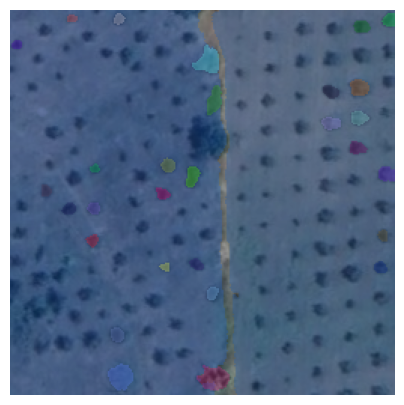

In [21]:
plt.figure(figsize=(5,5))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show() 